In [1]:
import os
import tensorflow as tf
import numpy as np

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from tensorflow import keras
import tensorflow_datasets as tfds
from keras.datasets import fashion_mnist
import matplotlib.patches as patches
from PIL import Image

tfds.disable_progress_bar()

from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer,Lambda,InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

import cvnn.layers as complex_layers

import warnings
warnings.filterwarnings('ignore')

2022-10-09 12:01:56.753321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 12:01:56.938102: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-09 12:01:57.549670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-09 12:01:57.549755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [2]:
# pip install tensorflow==2.10.0 cvnn tensorflow_datasets

In [3]:
size = 200
Hz = 399e9
lam = 3e8 / Hz
z = 0.03
rect_length = 400e-6

# Define the traning parameters
BUFFER_SIZE = 5000
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 1

keep_training = False
learning_rate = 3e-3
epochs = 20

# load the dataset
datasets, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True, data_dir='./data')

fashion_mnist_train, fashion_mnist_test = datasets['train'], datasets['test']

num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

2022-10-09 12:02:04.070923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 12:02:04.080577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 12:02:04.080872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 12:02:04.082839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### 1.Peprocessing the images     
二值化， 1表示有光， 0表示无光

In [4]:
def preprocess(image, label):
    encode_in_phase_channel = False
    encode_in_amplitude_channel = not(encode_in_phase_channel)
    label = tf.one_hot(tf.cast(label, tf.int32), 10)   # convert the label to categorial, or one-hot coded
    
    up_sampling_size = int(0.8*size)
    padding_size = (size - up_sampling_size)//2
    image = tf.cast(image, tf.float32)
    # Step1: upsample the image 
    up_sampling_image = tf.image.resize(image,
                                        size=[up_sampling_size,up_sampling_size],
                                        method='nearest')
    up_sampling_image = up_sampling_image / 255.0
    
    # Step2: zeor padding
    zero_padded_image = tf.pad(up_sampling_image,
                                paddings=[[padding_size,padding_size],[padding_size,padding_size],[0,0]],
                                mode="CONSTANT",constant_values=0)
    if encode_in_amplitude_channel: 
        # Step3 :Binarize
        zeros = tf.zeros_like(zero_padded_image)
        ones = tf.ones_like(zero_padded_image)

        binarized_images = tf.where(zero_padded_image > 0.28, ones, zeros)  # 图像预处理: 转成二值图

        return tf.cast(binarized_images, dtype=tf.complex64), label
    
    if encode_in_phase_channel: 
        # Step3 : get phase image
        phase_image = tf.math.exp(2*np.pi*1j*tf.cast(zero_padded_image,dtype=tf.complex64))
        return phase_image, label
   
    
train_dataset = fashion_mnist_train.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = fashion_mnist_test.map(preprocess).batch(BATCH_SIZE)

#### Visualize the data

2022-10-09 12:02:16.381841: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


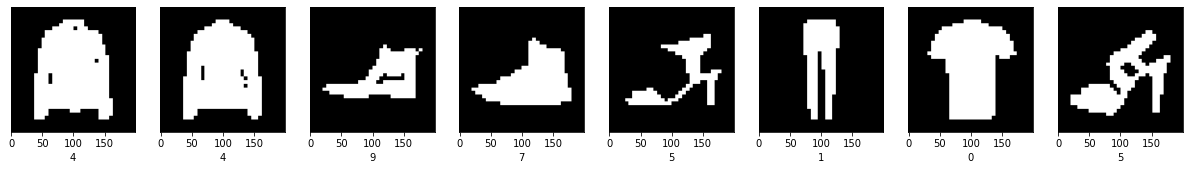

In [5]:
# plot the phase(angle) of the phase images
rows, cols = 1, BATCH_SIZE_PER_REPLICA
fig = plt.figure(figsize=(21,8))
for images, labels in test_dataset.take(1):
        for i in range(cols):
            fig.add_subplot(rows,cols,i+1)
            image = np.abs(images[i].numpy()).squeeze()
            # print(np.min(np.abs(images[i].numpy()).squeeze())) # check the amplitude of the phase object
            plt.imshow(image,cmap='gray')
            label = np.argmax(labels[i].numpy())
            ax = plt.gca()
            ax.axes.xaxis.set_visible(True)
            ax.axes.yaxis.set_visible(False)
            plt.xlabel(str(label))

### 2.Build the Diffraction layer using Angular Spectrum method

### Angular Spectrum Propagation
$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y)\mathcal{F}h(x,y)]$$

$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y) H(f_x,f_y)]$$


This can be described using Fourier transforms.The first Fourier transform decomposes the initial field into plane waves. To propagate the plane waves, we multiply each wave by a complex phase factor, and then we take the inverse Fourier transform to add all the propagated plane waves back together.

To implement Angular spectrum propagation, the Fouier transform of the initial field is first multiplied with the phase factor $$H=e^{ik_zz}$$, where $k_z$is a function of the spatial frequencies $$k_z=\sqrt{k^2-k_x^2-k_y}$$where $$  k = \frac{2\pi}{\lambda}$$ and $k_x$ and $k_y$ are related to the spatial frequencies $f_x$ and $f_y$ by a factor of $2\pi$ $$k_{x,y} = 2\pi f_{x,y}$$

Hence the complex exponential can be written in terms of the Fourier coordinates $f_x$ and $f_y$, that is 

$$H=e^{ik_zz},k_z = 2\pi \sqrt{\frac{1}{\lambda}-f_x-f_y}$$

Descretized spatial freqnency $f_x = k*\Delta f = \frac{k}{N \Delta x}$  
Interval between the spatial frequencies $\Delta f = \frac{1}{N \Delta x}=\frac{1}{L}$,where $L$ denotes the field of view in object space

In [6]:
class Diffraction_Layer(Layer):
    def __init__(self, size =size, Hz = Hz,z = z,rect_length = rect_length):
        super(Diffraction_Layer, self).__init__()
        self.size = size
        self.layer_size = size * rect_length       # layer size
        self.dx = rect_length
        self.prop_dist = z
        self.wavelength = 3e8/ Hz
        self.propagator = self.angular_spectrum_propagator()
   
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        phase_init = tf.random_normal_initializer()
        self.phase = tf.Variable(name= "phase",
                                initial_value=phase_init(shape=(self.size,self.size), dtype='float32'),
                                trainable=True,
                                constraint=lambda t: tf.where((t <2*np.pi)&(t >0), t,2*np.pi*tf.random.normal([1])))
                                # constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi)) # 这样做会让准确率降低
        # To help with the 3D-printing and fabrication of the D2NN design, 
        # a sigmoid function was used to constrain the phase value of each neuron
   
    def angular_spectrum_propagator(self):
        L = self.layer_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*np.pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')
    
    @tf.function
    def call(self, inputs):
        inputs = tf.cast(inputs, 'complex64')
        conv_x = tf.map_fn(self.apply_conv, inputs)
        return tf.multiply(conv_x,tf.math.exp(1j*tf.cast(self.phase,dtype=tf.complex64)))

    def apply_conv(self, x):
        conv_x = self.conv2dfft(self.propagator, x)
        return conv_x
             
    def conv2dfft(self, A, B):
        B = tf.signal.fft2d(tf.signal.fftshift(B))
        fftAB = tf.math.multiply(A, B)
        return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))
    

#### Notice
For ___tf.cast()___: In case of casting from real types to complex types(complex64), the imaginary part of the returned value is set to 0.    

In [7]:
class Propogation(Layer):
    def __init__(self, units =size,Hz = Hz, z = z, rect_length =rect_length):
        '''Initialize the diffraction layer attributes'''
        super(Propogation, self).__init__()
        self.layer_size = units * rect_length       # layer size
        self.dx = rect_length
        self.prop_dist = z
        self.wavelength = 3e8/ Hz
        self.propagator = self.angular_spectrum_propagator()
   
    def angular_spectrum_propagator(self):
        L = self.layer_size
        dx = self.dx
        prop_dist = self.prop_dist
        wavelength = self.wavelength
        fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
        [FX, FY] = np.meshgrid(fx, fx)
        H = np.exp(-1j*np.pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
        H = np.fft.fftshift(H)
        return tf.constant(H, 'complex64')
    
    @tf.function
    def call(self, inputs):
        inputs = tf.cast(inputs, 'complex64')
        conv_x = tf.map_fn(self.apply_conv, inputs)
        return conv_x

    def apply_conv(self, x):
        conv_x = self.conv2dfft(self.propagator, x)
        return conv_x
             
    def conv2dfft(self, A, B):
        B = tf.signal.fft2d(tf.signal.fftshift(B))
        fftAB = tf.math.multiply(A, B)
        return tf.signal.ifftshift(tf.signal.ifft2d(fftAB))
        

In [8]:
class Detector(Layer):
    def __init__(self, units=200):
        '''Initialize the instance attributes'''
        super(Detector, self).__init__()
        self.units = units
    
    @tf.function
    def call(self, inputs):
        ''' Converts output to one hot form
        Applies softmax'''
        
        def rang(arr,shape,size=size,base = 500):
            x0 = shape[0] * size // base
            y0 = shape[2] * size // base
            delta = (shape[1]-shape[0])* size // base
            return arr[x0:x0+delta,y0:y0+delta]
        
        def reduce_mean(tf_):
            return tf.reduce_mean(tf_)
        
        def _ten_regions(a):
            return tf.map_fn(reduce_mean,tf.convert_to_tensor([
                rang(a,(120,170,120,170)),
                rang(a,(120,170,240,290)),
                rang(a,(120,170,360,410)),
                rang(a,(220,270,120,170)),
                rang(a,(220,270,200,250)),
                rang(a,(220,270,280,330)),
                rang(a,(220,270,360,410)),
                rang(a,(320,370,120,170)),
                rang(a,(320,370,240,290)),
                rang(a,(320,370,360,410))
            ]))
        
        def ten_regions(logits):
            return tf.map_fn(_ten_regions,tf.abs(logits),dtype=tf.float32)

        return tf.nn.softmax(ten_regions(tf.abs(inputs))) # logits_abs

In [9]:
def loss_function(y_label,logits_abs):
    return tf.reduce_sum(tf.square(logits_abs-y_label))

In [10]:
def get_D2NN_model():
    inputs = complex_layers.complex_input(shape=(size,size))
    h1 = Diffraction_Layer(size,Hz,z)(inputs)
    h2 = Diffraction_Layer(size,Hz,z)(h1)
    h3 = Diffraction_Layer(size,Hz,z)(h2)
    h4 = Diffraction_Layer(size,Hz,z)(h3)
    h5 = Diffraction_Layer(size,Hz,z)(h4)
    propogation = Propogation(size,Hz,z=0.01)(h5)
    out = Detector()(propogation)
    return tf.keras.Model(inputs, out)

D2NN = get_D2NN_model()

D2NN.summary()
# plot_model(D2NN, show_shapes=True, show_layer_names=True, to_file='D2NN-model.png')

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (ComplexInput)      [(None, 200, 200)]        0         
                                                                 
 diffraction__layer (Diffrac  (None, 200, 200)         40000     
 tion_Layer)                                                     
                                                                 
 diffraction__layer_1 (Diffr  (None, 200, 200)         40000     
 action_Layer)                                                   
                                                                 
 diffraction__layer_2 (Diffr  (None, 200, 200)         40000     
 action_Layer)                                                   
                                                                 
 diffraction__layer_3 (Diffr  (None, 200, 200)         40000     
 action_Layer)                                               

In [11]:
if keep_training:
    D2NN.load_weights('./training_results/D2NN_AS')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

D2NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             loss=loss_function,
             metrics=['accuracy'])

checkpoint_path = './training_results/D2NN_AS'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             sace_freq='epoch')

history = D2NN.fit(train_dataset,
                   epochs=epochs,
                   validation_data=test_dataset,
                   callbacks=[checkpoint])

Epoch 1/20
7500/7500 [==============================] - 1412s 188ms/step - loss: 5.7126 - accuracy: 0.6040 - val_loss: 5.3488 - val_accuracy: 0.6353
Epoch 2/20
7500/7500 [==============================] - 1393s 186ms/step - loss: 5.2592 - accuracy: 0.6462 - val_loss: 5.2200 - val_accuracy: 0.6310
Epoch 3/20
7500/7500 [==============================] - 1381s 184ms/step - loss: 5.1702 - accuracy: 0.6516 - val_loss: 5.1793 - val_accuracy: 0.6359
Epoch 4/20
7500/7500 [==============================] - 1389s 185ms/step - loss: 5.1323 - accuracy: 0.6520 - val_loss: 5.1436 - val_accuracy: 0.6491
Epoch 5/20
7500/7500 [==============================] - 1362s 182ms/step - loss: 5.1100 - accuracy: 0.6541 - val_loss: 5.1101 - val_accuracy: 0.6473
Epoch 6/20
7500/7500 [==============================] - 1338s 178ms/step - loss: 5.0902 - accuracy: 0.6545 - val_loss: 5.1045 - val_accuracy: 0.6393
Epoch 7/20
 577/7500 [=>............................] - ETA: 19:58 - loss: 5.0566 - accuracy: 0.6588

KeyboardInterrupt: 

### 3. Extracting weights from model
- Neurons’ phase values were converted into a relative height map (Δ𝑧=𝜆$\phi$/2𝜋Δ𝑛)    
  ,where Δ𝑛 is the refractive index difference between the 3D printing material (VeroBlackPlus RGD875) and air
- save the height map to a numpy file

In [12]:
D2NN.load_weights('./training_results/D2NN_AS')
# print(D2NN.layers)
# print(D2NN.layers[1].weights)
# print(D2NN.layers[5].get_weights()) # get the numpy arrays for the parameters of the layer
# print(D2NN.get_layer('diffraction__layer_4').phase)

# Extract all the weights from the model
weights = []
# D2NN 中的 diffraction layer 从第二层开始，第一层是 input layer
for l in range(1,2+1):
    weights.append(np.squeeze(D2NN.layers[l].get_weights())) 
    
# Map the weights into range [0, 2*pi]
for l in range(0,2):
    for i in range(0,size):
        for j in range(0,size):
            while (weights[l][i][j] < 0):
                    weights[l][i][j] += 2*np.pi
            while(weights[l][i][j] > 2*np.pi):
                weights[l][i][j] -= 2*np.pi
print("The max value in wights is: " + str(np.max(weights)))
print("The mim value in wights is: " + str(np.min(weights)))

The max value in wights is: 6.2830806
The mim value in wights is: 0.0010380625


In [42]:
# Convert the weights to height map
lam = 3e8 / Hz        # wavelength of the optical wave

# VeroBlackPlus RGD875, refractive index: 1.7227
# SiO2 (Glass) - Palik, Refractive Index: 1.47012
material_refractive_index = 1.7227
air_refractive_index = 1.0003

delta_n = material_refractive_index - air_refractive_index

height_map = (lam*np.array(weights)) / (2*np.pi*delta_n)         

# Check the shape and save it to np file
print("The shape of the height map for all layers:",end=' ')
print(np.shape(np.array(height_map)))
print("Max and min value in height_map are: " + str(np.max(height_map)) + ", "+ str(np.min(height_map))+"\n")

np.save('height_map.npy',np.array(height_map))
print("height_map.npy has saved successfully")

The shape of the height map for all layers: (2, 28, 28)
Max and min value in height_map are: 0.010172816, 0.0

height_map.npy has saved successfully


In [61]:
lam = 3e8 / Hz        # wavelength of the optical wave
material_refractive_index = 1.7227
air_refractive_index = 1.0003

delta_n = material_refractive_index - air_refractive_index
# get the height map for the filter
test_dataset = fashion_mnist_test.map(preprocess).batch(BATCH_SIZE)
for images, labels in test_dataset.take(1):
    images = tfds.as_numpy(images)
    for _ in range(1):
        image_phase = np.angle(images[15]).squeeze()
        for i in range(0,size):
            for j in range(0,size):
                while (image_phase[i][j] < 0):
                    image_phase[i][j] += 2*np.pi
                while(image_phase[i][j] > 2*np.pi):
                    image_phase[i][j] -= 2*np.pi
        # print(np.shape(image_phase))
        
        filter_height_map = (lam*np.array(image_phase)) / (2*np.pi*delta_n)
        np.save('filter_height_map.npy',np.array(filter_height_map))
        print("The shape of the filter height map for all layers:",end=' ')
        print(np.shape(np.array(filter_height_map)))
        print("Max and min value in height_map are: " + str(np.max(filter_height_map)) + ", "+ str(np.min(filter_height_map))+"\n")
        print("filter_height_map.npy has saved successfully")

The shape of the filter height map for all layers: (28, 28)
Max and min value in height_map are: 0.012105619, 0.0

filter_height_map.npy has saved successfully


### 4.Evaluation

In [ ]:
# """Plot the region of the ten detectors"""
# detector_plane = np.zeros([size,size])

# ten_detector_regions = [[120,170,120,170],
#                         [120,170,240,290],
#                         [120,170,360,410],
#                         [220,270,120,170],
#                         [220,270,200,250],
#                         [220,270,280,330],
#                         [220,270,360,410],
#                         [320,370,120,170],
#                         [320,370,240,290],
#                         [320,370,360,410]] 

# def get_range(shape,size=size,base = 500):
#             x0 = shape[0] * size // base
#             y0 = shape[2] * size // base
#             delta = (shape[1]-shape[0])* size // base
#             x1 = x0+delta
#             y1 = y0+delta
#             return x0,x1,y0,y1

# for i in range(0,10):
#     x0,x1,y0,y1 = get_range(ten_detector_regions[i])
#     # print([x0,x1,y0,y1])
#     detector_plane[x0:x1,y0:y1] = 1

# # plot the detector region
# rows, cols = 1 ,1
# fig = plt.figure(figsize=(7,7))
# plt.imshow(detector_plane,cmap='gray')

In [16]:
# predict for a bunch(= buffer size = 16) image
for images, labels in test_dataset.take(1):
    label =  np.argmax(labels[:].numpy(), axis=1)
    predict = np.argmax(D2NN.predict(images,verbose=0), axis=1)
    print("Ground truth:    ", label)
    print("Predicted result:" , predict)
    print(label==predict)

Ground truth:     [4 4 9 7 5 1 0 5]
Predicted result: [2 4 9 9 5 1 0 5]
[False  True  True False  True  True  True  True]


### 5.Simulation in Python

In [13]:
def angular_spectrum_propagator(x, z=z): # x: input U0
    L = size * rect_length
    dx = rect_length
    prop_dist = z
    wavelength = 3e8/ Hz
    fx = np.arange(-1/(2*dx), 1/(2.*dx), 1/L)
    [FX, FY] = np.meshgrid(fx, fx)
    H = np.exp(-1j*np.pi*wavelength*prop_dist*(np.square(FX) + np.square(FY)))
    H = np.fft.fftshift(H)
    
    def conv2dfft(A, B):
        B = np.fft.fft2(np.fft.fftshift(B))
        fftAB = np.multiply(A, B)
        return np.fft.ifftshift(np.fft.ifft2(fftAB))
    return conv2dfft(H, x) # U1

In [14]:
D2NN.load_weights('./training_results/D2NN_AS')
phase = []
# D2NN 中的 diffraction layer 从第二层开始，第一层是 input layer
for l in range(1,5+1):
    phase.append(np.squeeze(D2NN.layers[l].get_weights()))
print(np.shape(phase[0][:][:]))

(200, 200)


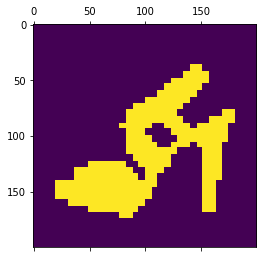

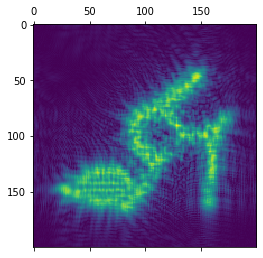

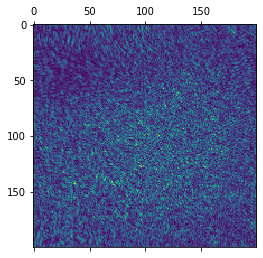

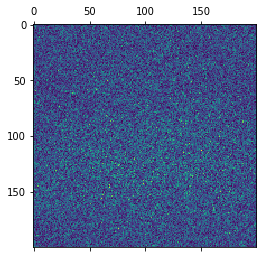

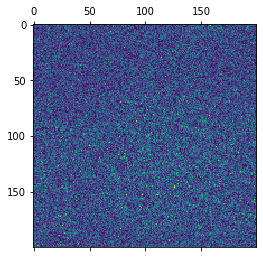

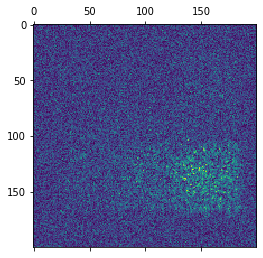

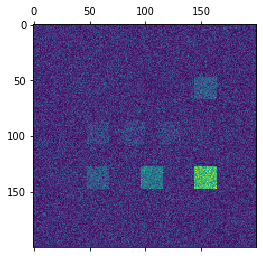

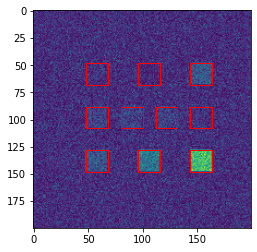

In [37]:
for images, labels in test_dataset.take(1):
    image = images[7].numpy().squeeze()
    U0 = image
result_image = []
plt.matshow(np.abs(U0))
result_image.append(np.abs(U0))

P1 = angular_spectrum_propagator(U0)
plt.matshow(np.abs(P1))
result_image.append(np.abs(P1))

t_0 = np.exp(1j*phase[0][:][:])
P2 = angular_spectrum_propagator(P1*t_0)
plt.matshow(np.abs(P2))
result_image.append(np.abs(P2))

t_1 = np.exp(1j*phase[1][:][:])
P3 = angular_spectrum_propagator(P2*t_1)
plt.matshow(np.abs(P3))
result_image.append(np.abs(P3))

t_2 = np.exp(1j*phase[2][:][:])
P4 = angular_spectrum_propagator(P3*t_2)
plt.matshow(np.abs(P4))
result_image.append(np.abs(P4))

t_3 = np.exp(1j*phase[3][:][:])
P5 = angular_spectrum_propagator(P4*t_3)
plt.matshow(np.abs(P5))
result_image.append(np.abs(P5))

t_4 = np.exp(1j*phase[4][:][:])
P6 = angular_spectrum_propagator(P5*t_4,z=0.01)
plt.matshow(np.abs(P6))
result_image.append(np.abs(P6))

detector_plane = P6

def detector_region():
    fig, ax = plt.subplots()# Create figure and axes
    ax.imshow(np.abs(detector_plane))# Display the image
    i = size/500
    delta = int(i*170) - int(i*120)
    detector_0 = patches.Rectangle((int(i*240), int(i*120)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_1 = patches.Rectangle((int(i*360), int(i*120)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_2 = patches.Rectangle((int(i*120), int(i*120)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_3 = patches.Rectangle((int(i*120), int(i*220)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_4 = patches.Rectangle((int(i*200), int(i*220)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_5 = patches.Rectangle((int(i*280), int(i*220)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_6 = patches.Rectangle((int(i*360), int(i*220)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_7 = patches.Rectangle((int(i*120), int(i*320)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_8 = patches.Rectangle((int(i*240), int(i*320)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')
    detector_9 = patches.Rectangle((int(i*360), int(i*320)), delta, delta, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(detector_0)
    ax.add_patch(detector_1)
    ax.add_patch(detector_2)
    ax.add_patch(detector_3)
    ax.add_patch(detector_4)
    ax.add_patch(detector_5)
    ax.add_patch(detector_6)
    ax.add_patch(detector_7)
    ax.add_patch(detector_8)
    ax.add_patch(detector_9)
    plt.show()
   
    
detector_region()

In [42]:
# monitor = []
def animate(i):
    print(i)
    image = result_image[i]
    # monitor.append(np.abs(U1))
    ax.imshow(np.abs(image))

ani = animation.FuncAnimation(fig, animate, frames= 7, interval=2000)
ani.save('AS_animation.gif',writer='pillow',fps=1,dpi=200)

0
0
1
2
3
4
5
6
